In [ ]:
# ==============================================================================
# LANGKAH 0: PENGATURAN AWAL, REPRODUCIBILITY & MOUNT DRIVE
# ==============================================================================
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Input,
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.models import Model

# Mengatur seed untuk memastikan hasil yang selalu sama setiap kali dijalankan
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
# LANGKAH 1: EKSTRAK DATASET DARI ZIP KE PENYIMPANAN LOKAL COLAB
# ==============================================================================
ZIP_PATH = "/content/drive/MyDrive/data.zip"
EXTRACT_PATH = "/content/dataset_local/"

print(f"Mengekstrak '{ZIP_PATH}' ke '{EXTRACT_PATH}'...")
# Menggunakan opsi -qn agar tidak menimpa file dan tidak berisik (quiet)
!unzip -qn "{ZIP_PATH}" -d "{EXTRACT_PATH}"
print("✅ Ekstraksi selesai.\n")

Mengekstrak '/content/drive/MyDrive/data.zip' ke '/content/dataset_local/'...
✅ Ekstraksi selesai.



In [ ]:
# ==============================================================================
# LANGKAH 2: PERSIAPAN DATAFRAME DARI DATA ASLI
# ==============================================================================
print("Mempersiapkan DataFrame dari file-file asli...")
local_data_dir = pathlib.Path(EXTRACT_PATH) / 'data'

# Hanya cari file .jpg (data asli), abaikan .JPG (augmentasi lama jika ada)
filepaths_id = list(local_data_dir.glob('**/*.jpg'))
labels_id = [str(fp.parent.name) for fp in filepaths_id]
df_id = pd.DataFrame({'file_path': [str(fp) for fp in filepaths_id], 'label': labels_id})

# Pisahkan antara data training/validasi dan data tes
df_train_full = df_id[~df_id['file_path'].str.contains('/test/')].copy()
df_test = df_id[df_id['file_path'].str.contains('/test/')].copy()

# Buat set validasi dari data training
df_train, df_val = train_test_split(
    df_train_full, test_size=0.2, random_state=SEED, stratify=df_train_full['label']
)

# Definisikan nama kelas dan mapping ke angka
class_names = sorted(df_train['label'].unique())
NUM_CLASSES = len(class_names)
label_to_idx = {label: i for i, label in enumerate(class_names)}

for df_ in [df_train, df_val, df_test]:
    df_['label_idx'] = df_['label'].map(label_to_idx)

print("✅ DataFrame siap digunakan.")
print(f"   -> {len(df_train)} gambar training")
print(f"   -> {len(df_val)} gambar validasi")
print(f"   -> {len(df_test)} gambar testing\n")

Mempersiapkan DataFrame dari file-file asli...
✅ DataFrame siap digunakan.
   -> 5592 gambar training
   -> 1399 gambar validasi
   -> 1076 gambar testing



In [ ]:
# ==============================================================================
# LANGKAH 3: MEMBUAT PIPELINE tf.data
# ==============================================================================
IMG_SIZE = 224
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def parse_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return img, label

def configure_dataset(ds, shuffle=False):
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=SEED)
    ds = ds.map(parse_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_dataset(tf.data.Dataset.from_tensor_slices((df_train['file_path'].values, df_train['label_idx'].values)), shuffle=True)
val_ds = configure_dataset(tf.data.Dataset.from_tensor_slices((df_val['file_path'].values, df_val['label_idx'].values)))
test_ds = configure_dataset(tf.data.Dataset.from_tensor_slices((df_test['file_path'].values, df_test['label_idx'].values)))
print("✅ Pipeline tf.data siap digunakan.\n")

✅ Pipeline tf.data siap digunakan.



In [ ]:
# ==============================================================================
# LANGKAH 4: MEMBUAT DAN MELATIH MODEL A (CLASS WEIGHTS)
# ==============================================================================
print("\n" + "="*50)
print("--- Memulai Training Model A (Class Weights) ---")
print("="*50)

# --- Fungsi untuk membuat arsitektur model ---
def create_model():
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal", seed=SEED),
        RandomRotation(0.1, seed=SEED),
        RandomZoom(0.1, seed=SEED),
    ], name="augmentation")
    base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    return Model(inputs, outputs), base_model

model_A, base_model_A = create_model()

# --- Hitung class weights untuk menangani data tidak seimbang ---
class_weights_dict = dict(enumerate(class_weight.compute_class_weight(
    'balanced', classes=np.unique(df_train['label_idx']), y=df_train['label_idx']
)))
print(f"Class Weights yang digunakan: {class_weights_dict}\n")

# --- Tahap 1: Training Awal (hanya melatih 'head' model) ---
print("--- Memulai Training Awal ---")
model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_A = model_A.fit(train_ds, validation_data=val_ds, epochs=10, class_weight=class_weights_dict, verbose=1)

# --- Tahap 2: Fine-Tuning (melatih beberapa layer terakhir dari 'base') ---
print("\n--- Memulai Fine-Tuning ---")
base_model_A.trainable = True
for layer in base_model_A.layers[:-40]: layer.trainable = False # Bekukan semua kecuali 40 layer terakhir
model_A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model_A.fit(train_ds, validation_data=val_ds, epochs=15, initial_epoch=10, class_weight=class_weights_dict, verbose=1)
print("\n✅ Training Model A selesai.")


--- Memulai Training Model A (Class Weights) ---
Class Weights yang digunakan: {0: np.float64(0.8194607268464243), 1: np.float64(0.8321428571428572), 2: np.float64(3.6030927835051547), 3: np.float64(0.768976897689769)}

--- Memulai Training Awal ---
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.4294 - loss: 1.4177 - val_accuracy: 0.8127 - val_loss: 0.5112
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.7838 - loss: 0.5815 - val_accuracy: 0.8663 - val_loss: 0.3735
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.8242 - loss: 0.4734 - val_accuracy: 0.8828 - val_loss: 0.3505
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - accuracy: 0.8445 - loss: 0.4321 - val_accuracy: 0.8964 - val_loss: 0.2931
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.8816 - loss: 0.3492 - val_accuracy: 0.8999 - val_loss: 0.2827
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.8750 - loss: 0.3534 - val_accuracy: 0


--- ANALISIS PERFORMA FINAL MODEL A PADA TEST SET ---
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step

--- CLASSIFICATION REPORT ---
                    precision    recall  f1-score   support

       Coccidiosis       0.99      0.93      0.96       343
           Healthy       0.87      0.93      0.90       304
New Castle Disease       0.83      0.82      0.82        77
        Salmonella       0.93      0.93      0.93       352

          accuracy                           0.92      1076
         macro avg       0.90      0.90      0.90      1076
      weighted avg       0.92      0.92      0.92      1076


--- CONFUSION MATRIX ---


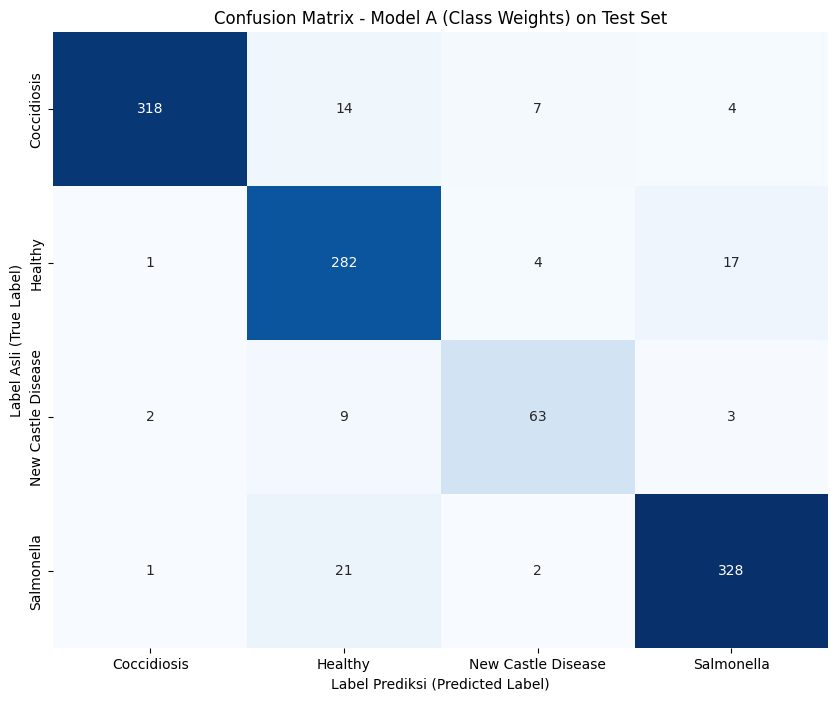

In [ ]:
# ==============================================================================
# LANGKAH 5: ANALISIS PERFORMA MODEL TERBAIK PADA DATA TES
# ==============================================================================
print("\n" + "="*60)
print("--- ANALISIS PERFORMA FINAL MODEL A PADA TEST SET ---")
print("="*60)

# Ambil label asli dari test set
y_true = df_test['label_idx'].values

# Buat prediksi dari model
predictions_prob = model_A.predict(test_ds)
y_pred = np.argmax(predictions_prob, axis=1)

# --- Tampilkan Classification Report ---
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- Visualisasi Confusion Matrix ---
print("\n--- CONFUSION MATRIX ---")
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Model A (Class Weights) on Test Set')
plt.ylabel('Label Asli (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - accuracy: 0.9137 - loss: 0.2420
loss: 0.2204388529062271 metrics: [0.9210036993026733]


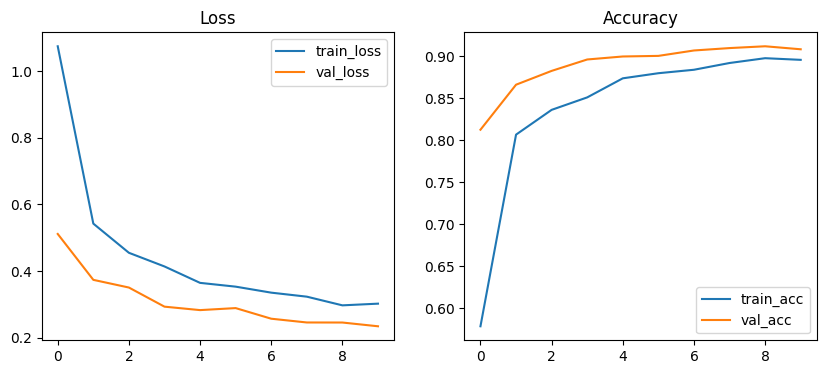

In [ ]:
# evaluasi
loss, *metrics = model_A.evaluate(test_ds, verbose=1)
print("loss:", loss, "metrics:", metrics)

# plot history jika ada
import matplotlib.pyplot as plt
if 'history_A' in globals():
    h = history_A.history
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(h['loss'], label='train_loss'); plt.plot(h.get('val_loss',[]), label='val_loss'); plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2);
    # asumsi metric akurasi bernama 'accuracy' atau 'auc' sesuai training
    if 'accuracy' in h: plt.plot(h['accuracy'], label='train_acc'); plt.plot(h.get('val_accuracy',[]), label='val_acc'); plt.legend(); plt.title('Accuracy')
    plt.show()

In [ ]:
# Simpan model Anda dalam format Keras native (direkomendasikan)
model_A.save('chikinspect_model_A.keras')

# Anda juga bisa menyimpannya ke Google Drive
model_A.save('/content/drive/MyDrive/chikinspect_model_A.keras')

In [ ]:
import tensorflow as tf

# Load model dalam format Keras native (.keras)
model = tf.keras.models.load_model('/content/drive/MyDrive/chikinspect_model_A.keras')
model.summary()

# lihat nama output dan bentuknya
print("Output names:", model.output_names)
print("Output shape:", model.output_shape)

# kalau model dilatih pakai ImageDataGenerator, bisa juga coba cek
try:
    # Note: class_indices is typically for Keras's built-in ImageDataGenerator
    # For models trained with tf.data, you might not have this attribute directly.
    print("Class indices:", model.class_indices)
except AttributeError:
    print("No class_indices attribute found (expected for models trained with tf.data).")

# Jika model dibuat dari flow_from_directory dan disimpan lengkap,
# bisa juga coba atribut ini:
if hasattr(model, 'classes'):
    print("Classes:", model.classes)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,636,430 (21.50 MB)

 Trainable params: 1,686,660 (6.43 MB)

 Non-trainable params: 576,448 (2.20 MB)

 Optimizer params: 3,373,322 (12.87 MB)

Output names: ListWrapper(['dense_1'])
Output shape: (None, 4)
No class_indices attribute found (expected for models trained with tf.data).
